In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
S_0 = 50
K = 50
T = 1
r = 0.08
sigma = 0.3

In [4]:
m = 1500
v_max = 1500
x_min = -1
x_max = 1
dx = (x_max - x_min) / m
dt = 0.5 * (sigma**2) * T / v_max  
d = 0
lam = dt / (dx * dx)

In [5]:
q_d = 2*(r - d)/(sigma**2)
q = 2*r/(sigma**2)

In [6]:
x_grid = x_min + np.arange(m + 1) * dx
def G(x, tau):
    return np.exp(0.25 * tau * ((q_d - 1.0)**2 + 4.0 * q)) * np.maximum(
        np.exp(0.5 * x * (q_d - 1.0)) - np.exp(0.5 * x * (q_d + 1.0)),
        0.0
    )

In [7]:
A = np.zeros((m - 1, m - 1))
theta = 0.5
alpha = lam * theta
for i in range(m - 1):
    A[i, i] = 1.0 + 2.0 * lam * theta
    if (i + 1) < (m - 1):
        A[i, i + 1] = -lam * theta
        A[i + 1, i] = -lam * theta
A

array([[17.875 , -8.4375,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [-8.4375, 17.875 , -8.4375, ...,  0.    ,  0.    ,  0.    ],
       [ 0.    , -8.4375, 17.875 , ...,  0.    ,  0.    ,  0.    ],
       ...,
       [ 0.    ,  0.    ,  0.    , ..., 17.875 , -8.4375,  0.    ],
       [ 0.    ,  0.    ,  0.    , ..., -8.4375, 17.875 , -8.4375],
       [ 0.    ,  0.    ,  0.    , ...,  0.    , -8.4375, 17.875 ]])

In [8]:
y = np.zeros((v_max + 1, m + 1))
y[0, :] = G(x_grid, 0.0)
for v in range(1, v_max + 1):
    y[v, 0] = G(x_grid[0], v * dt)
    y[v, m] = G(x_grid[m], v * dt) 

In [9]:
w = y[0, 1:m].copy()  

for v in range(v_max):
    b = np.zeros(m - 1)

    g0_v  = G(x_grid[0],     v * dt)
    g0_v1 = G(x_grid[0], (v + 1) * dt)
    b[0] = w[0] + lam * (1.0 - theta) * (w[1] - 2.0 * w[0] + g0_v) + alpha * g0_v1

    for i in range(1, m - 2):
        b[i] = w[i] + lam * (1.0 - theta) * (w[i + 1] - 2.0 * w[i] + w[i - 1])

    gM_v  = G(x_grid[m], v * dt)
    gM_v1 = G(x_grid[m], (v + 1) * dt)
    b[m - 2] = w[m - 2] + lam * (1.0 - theta) * (w[m - 3] - 2.0 * w[m - 2] + gM_v) + alpha * gM_v1
    g = np.zeros(m - 1)
    for i in range(m - 1):
        g[i] = G(x_grid[i + 1], (v + 1) * dt)  

    V = np.maximum(w, g)

    eps = 1e-8
    wr = 1.5   
    max_iter = 20000

    for _ in range(max_iter):
        V_new = V.copy()

        for i in range(m - 1):
            v_im1_new = 0.0 if i == 0     else V_new[i - 1]  
            v_ip1     = 0.0 if i == m - 2 else V[i + 1]     
            rho = (b[i] + alpha * (v_im1_new + v_ip1)) / (1.0 + 2.0 * alpha)

            temp = V[i] + wr * (rho - V[i])
            V_new[i] = max(g[i], temp)  

        diff = np.linalg.norm(V_new - V, 2)
        V = V_new
        if diff <= eps:
            break
    w = V
    y[v + 1, 1:m] = w


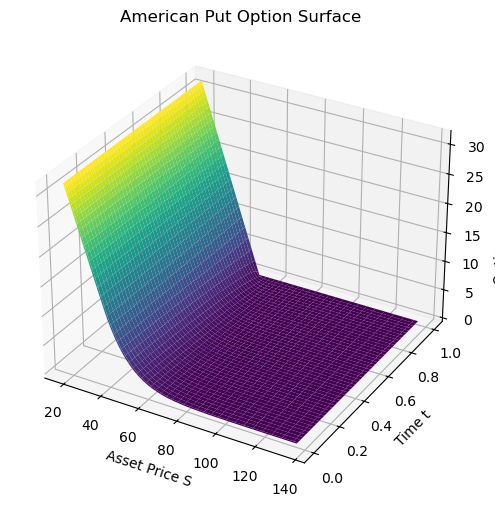

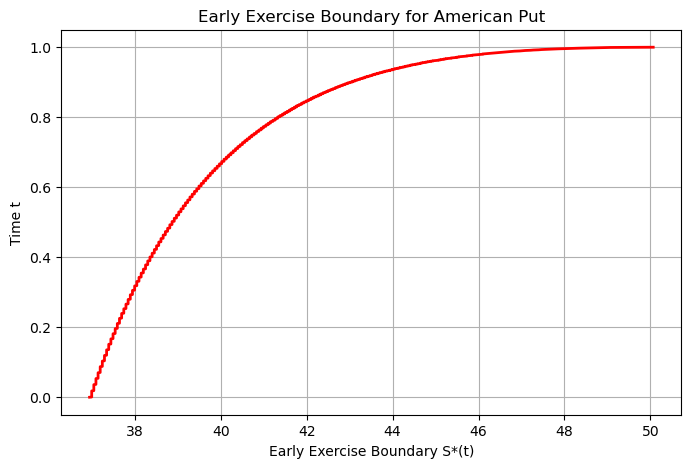

In [23]:
# --- Back-transform y to option values V(S,t) ---
x_grid = np.linspace(x_min, x_max, m+1)
S_grid = K * np.exp(x_grid)

V_vals = np.zeros_like(y)  # same shape (v_max+1, m+1)
t_grid = np.zeros(v_max+1)

for v in range(v_max+1):
    tau_v = v * dt
    t_grid[v] = T - 2.0 * tau_v / (sigma**2)
    factor_tau = np.exp(-0.25*((q_d-1)**2 + 4*q) * tau_v)
    for i in range(m+1):
        x_i = x_grid[i]
        factor_x = np.exp(-0.5*(q_d - 1)*x_i)
        factor = factor_x * factor_tau
        V_vals[v,i] = K * factor * y[v,i]

# --- Early exercise boundary ---
Sf = np.zeros(v_max+1)
for v in range(v_max+1):
    for i in range(m+1):
        s = K*np.exp(x_grid[i])
        if abs(V_vals[v][i] - (K - s)) > 1e-6:
            Sf[v] = s
            break
    

# --- Plot option surface ---
from mpl_toolkits.mplot3d import Axes3D

T_mesh, S_mesh = np.meshgrid(t_grid, S_grid)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_mesh, T_mesh, V_vals.T, cmap='viridis')
ax.set_xlabel("Asset Price S")
ax.set_ylabel("Time t")
ax.set_zlabel("Option Price V(S,t)")
ax.set_title("American Put Option Surface")
plt.show()

# --- Plot early exercise curve ---
plt.figure(figsize=(8,5))
plt.plot(Sf, t_grid, 'r-', linewidth=2)
plt.ylabel("Time t")
plt.xlabel("Early Exercise Boundary S*(t)")
plt.title("Early Exercise Boundary for American Put")
plt.grid(True)
plt.show()
